In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression

In [108]:
# Load data
datapath = os.path.join("data", "mosquito_data_part_2.csv")
mosquito_data = pd.read_csv(datapath)
mosquito_data.head(7)

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9
5,2019,39,21XX N CANNON DR,T054C,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.921777,-87.632140,9
6,2019,39,11XX W ROOSEVELT RD,T048,GRAVID,2019-09-26 00:09:00,3,negative,CULEX RESTUANS,41.866915,-87.654919,9


In [109]:
print(f"The data has {mosquito_data.shape[0]} rows and {mosquito_data.shape[1]} columns.")
mosquito_data.info() # Check for missing values and column data types

The data has 18495 rows and 12 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


The data has no missing values and all columns have the correct data types.

In [110]:
# Check for duplicates
mosquito_data.duplicated().sum()
print(f"There are {mosquito_data.duplicated().sum()} duplicates. In this case, I will remove the last occurance of each duplicate.")

There are 658 duplicates. In this case, I will remove the last occurance of each duplicate.


In [111]:
# removing the last occurance of each duplicate
mosquito_data.drop_duplicates(keep= "first", inplace = True)
print(f"After removing the last occurance of each duplicate, the data has {mosquito_data.duplicated().sum()} duplicates.")

After removing the last occurance of each duplicate, the data has 0 duplicates.


In [112]:
# basic descriptive statistics
mosquito_data.describe(exclude="object")

,Year,Week,Mosquito number,Lat,Lon,Month
count,17837.000000,17837.000000,17837.000000,17837.000000,17837.000000,17837.000000
mean,2012.850591,30.979088,10.458822,41.848969,-87.707359,7.621741
std,3.733999,4.377505,13.182843,0.114807,0.091859,1.006730
min,2007.000000,20.000000,1.000000,41.644720,-87.880969,5.000000
25%,2010.000000,28.000000,2.000000,41.746732,-87.770837,7.000000
50%,2013.000000,31.000000,4.000000,41.867599,-87.700238,8.000000
75%,2016.000000,34.000000,13.000000,41.962021,-87.643076,8.000000
max,2019.000000,40.000000,50.000000,42.017801,-87.531051,10.000000


Key takeaways:
- The data was collected from 2007 to 2019, from week 20 to week 40 (The month column above shows that it was from May to October).
- The minimum number of mosquitoes collected was 1 per trap, max was 50 with an average of 10.5 mosquitoes per trap.

In [113]:
mosquito_data.columns

Index(['Year', 'Week', 'Address Block', 'Trap', 'Trap type', 'Date',
       'Mosquito number', 'WNV Present', 'Species', 'Lat', 'Lon', 'Month'],
      dtype='object')

In [114]:
# Converting WNV Present to binary
mosquito_data['WNV Present'] = mosquito_data['WNV Present'].map({'negative': 0, 'positive': 1})

# Creating dummy variables for Trap type
mosquito_data = pd.get_dummies(mosquito_data, columns=['Trap type'], drop_first=True) 
#drop_first drops the CDC trap type and makes it the reference category

# Average number of moquitoes per month
mosquito_data.groupby('Month')['Mosquito number'].mean()

Month
5      2.761905
6     10.039783
7     11.053295
8     11.605926
9      8.156741
10     5.377778
Name: Mosquito number, dtype: float64

Takeaways:
- May had the minimum number of mosquitoes and August had the maximum number of mosquitoes on average
- The number of mosquitoes collected per month increased as the weather got hotter (May-August) and decreased in the fall season(September - October)

#### Investigating statistical difference between mosquito species by WNV Occurrence. 
We will use t-test to compare mosquito species by WNV Present

- Null Hypothesis, $H_{0}$: WNV occurrence is independent of mosquito species.
- Alternative Hypothesis, $H_{a}$: There is a relationship between WNV occurrence and mosquito species.



In [115]:
df = mosquito_data.astype({'WNV Present': 'object'})
df1 = pd.crosstab(df['Species'], df['WNV Present'])
stats.chi2_contingency(df1)


(288.313097009138,
 3.3649395840995687e-62,
 3,
 array([[4317.69978135,  993.30021865],
        [9257.3239334 , 2129.6760666 ],
        [ 180.48001346,   41.51998654],
        [ 745.49627179,  171.50372821]]))

The $\chi^2$ statistic is 288.31 with a very small p-value (second value in the tuple). This means that we can reject the null that mosquito species and the occurance of WNV are independent. There seem to be a relationship between the two.

<AxesSubplot:>

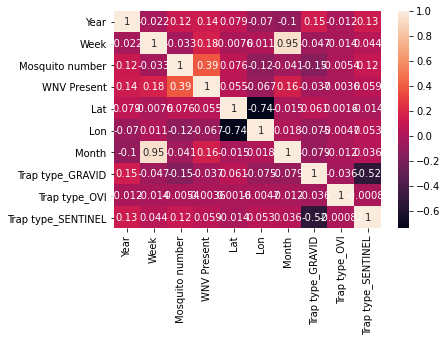

In [116]:
# Investigating the correlation between the variables
mosquito_data.corr()
# heatmap of the correlation between the variables
sns.heatmap(mosquito_data.corr(), annot=True)

Observations:
- The number of mosquitoes is positively correlated with WNV present (corr = 0.39)
- There is a slight positive correlation between the number of mosquitoes and Year, Lat, and SENTINEL trap type. 
- Mosquito number is negatively correlated with Week, Long, Month, other trap types (GRAVID, OVI)

Let's investigate if these correlation are statistically significant.

In [117]:
# Checking the significance of negative correlations with mosquito number
correlations = ['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Trap type_OVI', 'WNV Present', 'Year', 'Lat', 'Trap type_SENTINEL']

for i in correlations:
    mosqnumber_i = stats.pearsonr(mosquito_data['Mosquito number'], mosquito_data[i])
    print(f"The correlation between Mosquito number and {i} is {mosqnumber_i[0]:.2f} with a p-value of {mosqnumber_i[1]:.2f}. This means the correlation is {'statistically significant' if mosqnumber_i[1]< 0.05 else 'not statistically significant'}.")

The correlation between Mosquito number and Week is -0.03 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Lon is -0.12 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Month is -0.04 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Trap type_GRAVID is -0.15 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Trap type_OVI is -0.01 with a p-value of 0.47. This means the correlation is not statistically significant.
The correlation between Mosquito number and WNV Present is 0.39 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Year is 0.12 with a p-value of 0.00. This means the correlation is statistically significan

In [118]:
# Defining dependent and independent variables
ind_cols = ['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Trap type_SENTINEL', 'Trap type_OVI', 'Year', 'Lat']
X = mosquito_data[ind_cols]
X_with_constant = sm.add_constant(X)
y = mosquito_data['Mosquito number']
reg = sm.OLS(y, X_with_constant)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     139.1
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          9.26e-228
Time:                        15:37:32   Log-Likelihood:                -70769.
No. Observations:               17837   AIC:                         1.416e+05
Df Residuals:                   17828   BIC:                         1.416e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2547.4268    115

From the output above, we can see that $Trap type OVI$ is not statisticaly significant (which confirms our result from the correlation heatmap), however all other variables are significant p values close to 0. At this point, our model could be improved by removing the trap type_OVI. In addition, from the correlation heatmap, some independent variables exhihibit strong collinearity (e.g. Month vs Week, Lat vs Long).

- Month vs Week: The correlation coefficient is 0.95, which means that having one variable could highly estimate the other. I will keep Week in the model and drop Month
- Lat vs Long: There is a negative correlation of -0.74, I will remove Long from the model

Now let's fit the model again without these variables. 

In [119]:
# Defining dependent and independent variables
ind_cols1 = ['Week', 'Trap type_GRAVID', 'Trap type_SENTINEL', 'Year', 'Lat']
X1 = mosquito_data[ind_cols1]
X1_with_constant = sm.add_constant(X1)
y1 = mosquito_data['Mosquito number']
reg = sm.OLS(y1, X1_with_constant)
results1 = reg.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     185.4
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          4.16e-193
Time:                        15:37:32   Log-Likelihood:                -70857.
No. Observations:               17837   AIC:                         1.417e+05
Df Residuals:                   17831   BIC:                         1.418e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1300.1274     62

By removing multicollinear variables, Trap type_SENTINEL is no longer significant. We can now be confident that our model is accurate. The equation for the model is: 

$ y = -1300.1274 - 0.1152 * WEEK - 11.0682 * GRAVID + 1.6788 * SENTINEL + 0.4791 * YEAR + 8.6126 * LAT $

The model can be interpreted as follows. By keeping other variables constant, 
- The number of mosquitoes reduces by 0.1152 per one WEEK increase
- The number of mosquitoes reduces by 11.0682 per one unit increase in GRAVID trap type
- The number of mosquitoes increases by 1.6788 per one unit increase in SENTINEL trap type
- The number of mosquitoes increases by 0.4791 per one unit increase in YEAR
- The number of mosquitoes increases by 8.6126 per one unit increase in LATITUDE

The $R^2$ value is 0.049, which means that only 4.9% of the total variance in mosquito number is explained by our model. This means, linear regression is not the best model to predict mosquito number in our data!

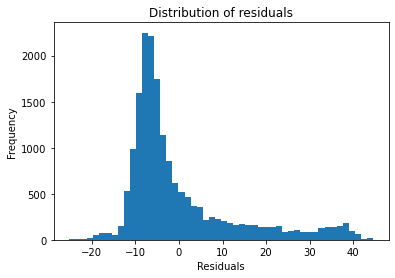

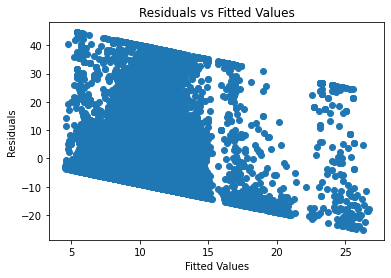

In [120]:
# performing linear model diagnostics
## are residuals normally distributed?

results1.resid.plot(kind='hist', bins=50)
plt.title('Distribution of residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## checking for homoscedasticity
plt.figure()
plt.plot(results1.fittedvalues, results1.resid, 'o')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

From the figures above:
- (1) Residuals are not normally distributed. The distribution of residuals seems to be right skewed, which confirms linear regression might not be the best model to predict mosquito number.
- (2) Also, there seem to be a downward trend in the variance of residuals as the fitted values increase, which is consistent with the fact that the model is not a good fit to our data!

Let's now fit a logistic regression to model the presence of WNV in the data. Therefore, WNP present is our target variable and we will select our predictors. Let's look at the the correlation between all the variables and WNP present using the process used above. 

In [125]:
# the proportions of WNV Present
mosquito_data['WNV Present'].value_counts(normalize=True)

0    0.812973
1    0.187027
Name: WNV Present, dtype: float64

The output above shows that there is a very high imbalance between the two classes. Although the classification accuracy may be impacted by class imbalance, we will still go ahead and use logistic regression to model the data.

In [121]:
# Checking the significance of negative correlations with mosquito number
corr_cols = ['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Trap type_OVI', 'Year', 'Lat', 'Trap type_SENTINEL', 'Mosquito number']

for i in correlations:
    wnv_i = stats.pearsonr(mosquito_data['WNV Present'], mosquito_data[i])
    print(f"The correlation between WNV Present and {i} is {wnv_i[0]:.2f} with a p-value of {wnv_i[1]:.2f}. This means the correlation is {'statistically significant' if wnv_i[1]< 0.05 else 'not statistically significant'}.")

The correlation between WNV Present and Week is 0.18 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV Present and Lon is -0.07 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV Present and Month is 0.16 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV Present and Trap type_GRAVID is -0.04 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV Present and Trap type_OVI is -0.00 with a p-value of 0.63. This means the correlation is not statistically significant.
The correlation between WNV Present and WNV Present is 1.00 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV Present and Year is 0.14 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between WNV

In [122]:
# We will remove the variables that are not linearly correlated with WNV Present.
cols = ['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Year', 'Lat', 'Trap type_SENTINEL']
X2 = mosquito_data[cols]
X2_with_constant = sm.add_constant(X2)
y2 = mosquito_data['WNV Present']
reg = sm.OLS(y2, X2_with_constant)
results2 = reg.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:            WNV Present   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     157.3
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          2.09e-226
Time:                        15:37:32   Log-Likelihood:                -7976.8
No. Observations:               17837   AIC:                         1.597e+04
Df Residuals:                   17829   BIC:                         1.603e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -54.5270      3

All variables are statistically significant but Lat and SENTINEL. From the linear regression above, we know that some of our predictors exhibit a collinear relationship. Hence, it is a good idea to remove them. The variables to drop are Month and Longitude. 

In [123]:
ind_cols2 = ['Week', 'Trap type_GRAVID', 'Trap type_SENTINEL', 'Year', 'Lat', 'Mosquito number']
X3 = mosquito_data[ind_cols2]
X3_with_constant = sm.add_constant(X3)
y3 = mosquito_data['WNV Present']
reg = sm.OLS(y3, X3_with_constant)
results3 = reg.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:            WNV Present   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     731.8
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:37:32   Log-Likelihood:                -6547.7
No. Observations:               17837   AIC:                         1.311e+04
Df Residuals:                   17830   BIC:                         1.316e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -22.4777      1

Observations:
- Both GRAVID and SENTINEL have are not statistically significant.
- After removing collinear variables, the model's $R^2$ improves from 5.8% to 19.7%
- GRAVID ends up not being a good predictor of the presence of WNV after removing the collinear variables.

According to the above regression output, the model equation is:


$$P(y|X) = \frac{1}{1+e^{-(-22.4777 + 0.0172 * WEEK + 0.0299 * GRAVID + 0.0052 * SENTINEL + 0.0096 * YEAR + 0.0658 * LATITUDE + 0.0114 * MOSQ. NUMBER)}}$$

Let's calculate odds ratio for each of the predictors below


In [124]:
params = results3.params
confint = results3.conf_int()
confint['Odds Ratio'] = params
print(np.exp(confint))


                               0             1    Odds Ratio
const               5.915904e-12  5.059432e-09  1.730061e-10
Week                1.016105e+00  1.018493e+00  1.017298e+00
Trap type_GRAVID    9.982360e-01  1.063420e+00  1.030313e+00
Trap type_SENTINEL  9.487441e-01  1.065010e+00  1.005198e+00
Year                1.008137e+00  1.011067e+00  1.009601e+00
Lat                 1.020991e+00  1.117117e+00  1.067973e+00
Mosquito number     1.011077e+00  1.011884e+00  1.011480e+00


Interpretation:
- With one unit increase in Week, the odds of WNV presence increase by 1.73%
- With one unit increase in GRAVID trap type, the odds of WNV presence increase by 3.03%
- With one unit increase in SENTINEL trap type, the odds of WNV presence increase by 0.52%
- With one unit increase in YEAR, the odds of WNV presence increase by 0.96%
- With one unit increase in LATITUDE, the odds of WNV presence increase by 6.80%
- With one unit increase in mosquito number, the odds of WNV presence increase by 1.15%

Note that since Trap type_GRAVID and Trap type_SENTINEL 95% confidence intervals cover the null value (1), we actually do not have enough evidence to support the claim that increasing the number of traps increase the odds of WNV prevalence!


In [56]:
# Let's evaluate the performance of our model. 

model_predictions_prob = results3.predict(X3_with_constant) # probabilistic predictions
model_predictions_binary = np.where(model_predictions_prob>0.5,1,0) # binary predictions

correctly_predicted = (model_predictions_binary == mosquito_data['WNV Present']).sum()
print(f"The model classification accuracy is {round(correctly_predicted/len(mosquito_data) * 100, 2)}%.")


The model classification accuracy is 82.32%.


Note that our model may be overfit since we tested and validated the model on the same data!!
